# Salary Predict with Nonlinear Regression Models in Hitters Dataset

### This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

#### In this notebook, We will use Knn, Svr, CART, RF, GBM, XGBoost, LigthGBM, CatB from nonlinear models.

- A data frame with 322 observations of major league players on the following 20 variables.
- AtBat Number of times at bat in 1986
- Hits Number of hits in 1986
- HmRun Number of home runs in 1986
- Runs Number of runs in 1986
- RBI Number of runs batted in in 1986
- Walks Number of walks in 1986
- Years Number of years in the major leagues
- CAtBat Number of times at bat during his career
- CHits Number of hits during his career
- CHmRun Number of home runs during his career
- CRuns Number of runs during his career
- CRBI Number of runs batted in during his career
- CWalks Number of walks during his career
- League A factor with levels A and N indicating player’s league at the end of 1986
- Division A factor with levels E and W indicating player’s division at the end of 1986
- PutOuts Number of put outs in 1986
- Assists Number of assists in 1986
- Errors Number of errors in 1986
- Salary 1987 annual salary on opening day in thousands of dollars
- NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

### The results at the end of the notebook are as in the tables below. The best results were obtained with the RF model.

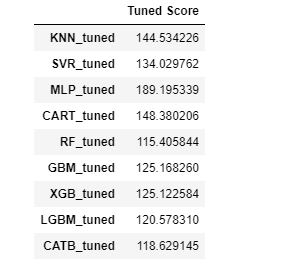

# 1. Data Understanding

In [ ]:
#Installation of required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [ ]:
#Reading the dataset
df = pd.read_csv("/kaggle/input/hitters/Hitters.csv")
df.head()

In [ ]:
#Feature information
df.info()

In [ ]:
#Summary information about features
df.describe().T

In [ ]:
df.shape

In [ ]:
# Number of unique observations in variables
df.nunique()

In [ ]:
#How many missing values?
df.isnull().sum()

In [ ]:
#Eksik verilere bakış
df[df["Salary"].isnull()].head()

In [ ]:
df["League"].value_counts()

In [ ]:
df["NewLeague"].value_counts()

In [ ]:
df["Division"].value_counts()

In [ ]:
#Distribution of dependent variable
sns.distplot(df.Salary);

In [ ]:
# Access to the correlation of the data set was provided. What kind of relationship is examined between the variables. 
# If the correlation value is> 0, there is a positive correlation. While the value of one variable increases, the value of the other variable also increases.
# Correlation = 0 means no correlation.
# If the correlation is <0, there is a negative correlation. While one variable increases, the other variable decreases. 
# When the correlations are examined, there are 2 variables that act as a positive correlation to the Salary dependent variable.
# These variables are CRBI and CRuns. As these increase, Salary (Salary) variable increases.
df.corr()

In [ ]:
# Correlation matrix graph of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap = "magma" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# 2. Data Preprocessing

In [ ]:
# The variables related to their careers were divided into career years and new values were created in the data set by obtaining average values.
df["AvgCAtBat"]=df["CAtBat"]/df["Years"]
df["AvgCHits"]=df["CHits"]/df["Years"]
df["AvgCHmRun"]=df["CHmRun"]/df["Years"]
df["AvgCRuns"]=df["CRuns"]/df["Years"]
df["AvgCRBI"]=df["CRBI"]/df["Years"]
df["AvgCWalks"]=df["CWalks"]/df["Years"]

df.head()

In [ ]:
#Based on some trials and correlation results, we subtract variables that do not contribute to the model from our data set.
df = df.drop(['AtBat','Hits','HmRun','Runs','RBI','Walks',"PutOuts",'Assists','Errors',
              'League','NewLeague',"Division"],axis=1)


In [ ]:
df.info()

In [ ]:
# Eksik gözlemlerin görselleştirilmesi için missingno kütüphanesi kullanılarak eksik gözlemler görselleştirilmiştir.
import missingno as msno
msno.bar(df);

In [ ]:
#We fill in the missing observations with the KNN method.
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 4)
df_filled = imputer.fit_transform(df)

In [ ]:
df = pd.DataFrame(df_filled,columns = df.columns)
df.head()

In [ ]:
#We conduct a stand alone observation review for the salary variable
#We suppress contradictory values
Q1 = df.Salary.quantile(0.25)
Q3 = df.Salary.quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
df.loc[df["Salary"] > upper,"Salary"] = upper

In [ ]:
#We determine outliers between all variables with the Lof method
from sklearn.neighbors import LocalOutlierFactor
lof =LocalOutlierFactor(n_neighbors= 10)
lof.fit_predict(df)

In [ ]:
df_scores = lof.negative_outlier_factor_

In [ ]:
np.sort(df_scores)[0:30]

In [ ]:
#We choose the threshold value according to lof scores
th = np.sort(df_scores)[7]
th

In [ ]:
#We delete those that are higher than the threshold
df = df[df_scores > th]

In [ ]:
df.shape

# 3. First Results

In [ ]:
models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP',MLPRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
models.append(("XGBoost", XGBRegressor()))
models.append(("LightGBM", LGBMRegressor()))
models.append(("CatBoost", CatBoostRegressor(verbose = False)))

In [ ]:
y = df["Salary"]
X = df.drop("Salary", axis=1)
cols = X.columns
cols

In [ ]:
#Feature Selection
#Wrapper Method
#Backward Elimination
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
import statsmodels.api as sm
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

In [ ]:
y = df["Salary"]
X = df[selected_features_BE]

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=46)

In [ ]:
for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        msg = "%s: (%f)" % (name, rmse)
        print(msg)

# 4. Model Tuning

 ## 4.1 KNN model tuning

In [ ]:
knn_params = {"n_neighbors": np.arange(1,30,1)}

knn_model = KNeighborsRegressor()

knn_cv_model = GridSearchCV(knn_model, knn_params, cv = 10).fit(X_train, y_train)

In [ ]:
knn_cv_model.best_params_

In [ ]:
knn_tuned = KNeighborsRegressor(**knn_cv_model.best_params_).fit(X_train, y_train)

In [ ]:
y_pred = knn_tuned.predict(X_test)
knn_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
knn_tuned_score

## 4.2 SVR model tuning

In [ ]:
#nonlinear
svr_model = SVR() 

svr_params = {"C": [0.01, 0.1,0.3,0.5,0.8,1,5, 10, 50, 100,500,1000,10000]}

svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 10, n_jobs = -1, verbose =  2).fit(X_train, y_train)

In [ ]:
svr_cv_model.best_params_

In [ ]:
svr_tuned = SVR(**svr_cv_model.best_params_).fit(X_train, y_train)

In [ ]:
y_pred = svr_tuned.predict(X_test)
svr_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
svr_tuned_score

## 4.3 CART model tuning

In [ ]:
cart_params = {"max_depth": [2,3,4,5,6,8,10,20,30,50, 100, 500, 1000,5000,10000],
              "min_samples_split": [2,5,10,20,30,50,100,500,1000,5000,10000]}

In [ ]:
cart_model = DecisionTreeRegressor()

In [ ]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10).fit(X_train, y_train)

In [ ]:
cart_cv_model.best_params_

In [ ]:
cart_tuned = DecisionTreeRegressor(**cart_cv_model.best_params_).fit(X_train, y_train)

In [ ]:
y_pred = cart_tuned.predict(X_test)
cart_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
cart_tuned_score

## 4.4 RF model tuning

In [ ]:
rf_params = {"max_depth": [5,10,None],
            "max_features": [2,5,10],
            "n_estimators": [100, 500, 1000],
            "min_samples_split": [2,10,30]}

In [ ]:
rf_model = RandomForestRegressor(random_state = 42).fit(X_train, y_train)

In [ ]:
rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [ ]:
rf_cv_model.best_params_

In [ ]:
rf_tuned = RandomForestRegressor(max_depth=30,
            max_features=3,
            n_estimators=1000,
            min_samples_split=3).fit(X_train, y_train)

In [ ]:
y_pred = rf_tuned.predict(X_test)
rf_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
rf_tuned_score

In [ ]:
Importance = pd.DataFrame({'Importance':rf_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 4.5 GBM model tuning

In [ ]:
gbm_params = {"learning_rate": [0.001,0.1,0.01],
             "max_depth": [3,5,8],
             "n_estimators": [200,500,1000],
             "subsample": [1,0.5,0.8]
             }

In [ ]:
gbm_model = GradientBoostingRegressor()

In [ ]:
gbm_cv_model = GridSearchCV(gbm_model, 
                            gbm_params, 
                            cv = 10, 
                            n_jobs=-1, 
                            verbose = 2).fit(X_train, y_train)

In [ ]:
gbm_cv_model.best_params_

In [ ]:
gbm_tuned = GradientBoostingRegressor(**gbm_cv_model.best_params_).fit(X_train, y_train)

In [ ]:
y_pred = gbm_tuned.predict(X_test)
gbm_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
gbm_tuned_score

In [ ]:
Importance = pd.DataFrame({'Importance':gbm_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 4.6 XGBoost model tuning

In [ ]:
xgb_params = {"learning_rate": [0.1,0.01,1],
             "max_depth": [2,5,8],
             "n_estimators": [100,500,1000],
             "colsample_bytree": [0.3,0.6,1]}

In [ ]:
xgb = XGBRegressor()

In [ ]:
xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [ ]:
xgb_cv_model.best_params_

In [ ]:
xgb_tuned = XGBRegressor(**xgb_cv_model.best_params_).fit(X_train, y_train)

In [ ]:
y_pred = xgb_tuned.predict(X_test)
xgb_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_tuned_score

In [ ]:
Importance = pd.DataFrame({'Importance':xgb_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 4.7 LightGBM model tuning

In [ ]:
lgb_model = LGBMRegressor()

In [ ]:
lgbm_params = {"learning_rate": [0.01, 0.1, 1],
              "n_estimators": [200,1000,10000],
              "max_depth": [2,5,10],
              "colsample_bytree": [1,0.5,0.3]}

In [ ]:
lgbm_cv_model = GridSearchCV(lgb_model, 
                             lgbm_params, 
                             cv = 10, 
                             n_jobs = -1, 
                             verbose =2).fit(X_train, y_train)

In [ ]:
lgbm_cv_model.best_params_

In [ ]:
lgbm_tuned = LGBMRegressor(learning_rate=0.01,
              n_estimators=300,
              max_depth=5,
              colsample_bytree=1).fit(X_train, y_train)

In [ ]:
y_pred = lgbm_tuned.predict(X_test)
lgbm_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_tuned_score

In [ ]:
Importance = pd.DataFrame({'Importance':lgbm_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 4.8 CatBoost model tuning

In [ ]:
catb_model = CatBoostRegressor(verbose = False)

In [ ]:
catb_params = {"iterations": [500,1000,10000],
              "learning_rate": [0.01,0.1,1],
              "depth": [2,6,10]}

In [ ]:
catb_cv_model = GridSearchCV(catb_model, 
                           catb_params, 
                           cv = 5, 
                           n_jobs = -1, 
                           verbose = 2).fit(X_train, y_train)

In [ ]:
catb_cv_model.best_params_

In [ ]:
catb_tuned = CatBoostRegressor(iterations=670,
              learning_rate=0.01,
              depth=6,verbose=False).fit(X_train, y_train)

In [ ]:
y_pred = catb_tuned.predict(X_test)
catb_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
catb_tuned_score

## 4.9 MLP model tuning

In [ ]:
mlp = MLPRegressor()

In [ ]:
mlp_params = {"alpha": [0.1, 0.01, 0.02, 0.001, 0.0001], 
             "hidden_layer_sizes": [(10,20), (5,5), (100,100), (1000,100,10)]}

In [ ]:
mlp_cv_model = GridSearchCV(mlp, mlp_params, cv = 10, verbose = 2, n_jobs = -1).fit(X_train, y_train)

In [ ]:
mlp_tuned = MLPRegressor(**mlp_cv_model.best_params_).fit(X_train, y_train)

In [ ]:
y_pred = mlp_tuned.predict(X_test)
mlp_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
mlp_tuned_score

In [ ]:
index = ["KNN_tuned","SVR_tuned","MLP_tuned","CART_tuned","RF_tuned","GBM_tuned","XGB_tuned","LGBM_tuned","CATB_tuned"]
tuned_score_df = pd.DataFrame({"Tuned Score":[knn_tuned_score,svr_tuned_score,mlp_tuned_score,cart_tuned_score,
                                              rf_tuned_score,gbm_tuned_score,xgb_tuned_score,lgbm_tuned_score,catb_tuned_score]})
tuned_score_df.index = index
tuned_score_df